# StaTexNet - Network Encoding Statistics for Textures

## Dependencies & Hyperparameters

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses

sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [3]:
#hyperparams
num_epochs = 200
batch_size = 1
crop_size = 128 
num_stats = 150
optimizer_type='adam'
#optimizer_type='sgd'
learning_rate = 0.001
num_crops = 5 #changed this to four

multistat_penalty = 0
sparsity_penalty = 0 #0.01
entropic_penalty = 0

#dataset location
#dtd_folder = '/gridsan/ckoevesdi/data/dtd_torch/dt/'
dtd_folder = 'home/gridsan/ckoevesdi/data/OT/dtd_torch/dtd/'

## Create Dataset and define DataLoader

In [4]:
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/OT/dtd_torch/', split='train', 
                                       partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen

#sampler = data.RandomSampler(dtd_dataset)

dtd_dataloader = DataLoader(dtd_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

tensor2pil_transform = transforms.ToPILImage()
print(len(dtd_dataset))

4183


In [5]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     128,
                                     128)).to(device)


Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(dtd_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    for i in range(texture_batch.shape[0]):  # Loop over batch
        mini_batch = texture_batch[i]  # This should have a shape of [5, 1, 128, 128]
        mini_batch = mini_batch.to(device)

        # Now you can call brucy, which expects a tensor with shape x,1,128,128 where x > 1
        statistics = brucy(mini_batch)  # This should output a tensor of shape [5, num_stats]
        
        # You can now store these statistics, along with the label and original image index
        all_statistics.append({
            'statistics': statistics.cpu().numpy(),
            #'label': labels[i].item(),
            'original_image_index': j * texture_batch.shape[0] + i
        })



In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
#print(statistics_array.shape)
labels_array = np.array([item['original_image_index'] for item in all_statistics])
# Standardize
scaler = StandardScaler()

reshaped_array = statistics_array.reshape(-1,num_stats)
#print(reshaped_array.shape)
scaled_array = scaler.fit_transform(reshaped_array)

statistics_array = scaled_array.reshape(len(dtd_dataset), 5, num_stats)
statistics_tensor = torch.tensor(statistics_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)


In [8]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)


In [9]:
# Create the DataLoader object first
batches = 100
statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

# Loop through a couple of batches
if(False):
    for i, (stats_batch, label_batch) in enumerate(statistics_dataloader):
        if i > 1:  # We only want to look at a couple of batches
            break

        print(f"Batch {i + 1}")

        # Dimensionality Check
        print("Statistics Batch Shape:", stats_batch.shape)  
        print("Label Batch Shape:", label_batch.shape)

        # Data Type Check
        print("Statistics Data Type:", stats_batch.dtype)
        print("Label Data Type:", label_batch.dtype)

        # Label Consistency (and value preview)
        print("Statistics:", stats_batch)
        print("Labels:", label_batch)


In [10]:
importlib.reload(sne)
statnet_model = sne.StatNetEncoder(img_size=(crop_size,crop_size),
                                   batch_size=batch_size,
                                   num_stats=num_stats,
                                   device=device)
stat_labels = statnet_model.getsstatlabels(device)
#optimizer
if(optimizer_type=='sgd'):
    optimizer = torch.optim.SGD(statnet_model.parameters(), lr=learning_rate)#, momentum=learning_momentum)
elif(optimizer_type=='adam'):
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adagrad'):
    optimizer = torch.optim.Adagrad(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adadelta'):
    optimizer = torch.optim.Adadelta(statnet_model.parameters(), lr=learning_rate)
else:
    print('No Optimizer Specified! Adam is default!')
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


## Implement new approaches

In [11]:
### Try with a single layer for the original approach

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 50)
        
    def forward(self, x):
        x = self.layer1(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=50, bias=True)
)


In [12]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
model = EmbeddingModel()
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
l2_weight = 0.01  # Regularization strength; adjust as required
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_epochs = 100
num_total_epochs = 1
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=50, bias=True)
)


In [13]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        #print(stats_batch.shape)
        stats_batch = torch.flatten(stats_batch, start_dim=0, end_dim=1)
        #print(stats_batch.shape) #torch.Size([batch_size, 5, num_stats])
        #print(label_batch) #label array of size batch_size containing image index
        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)
        perm = torch.randperm(batches * num_crops)

        #current_batch_size = stats

        stats_batch = stats_batch[perm]
        texture_labels = texture_labels[perm]

        stats_vector = model(stats_batch)
        #print(stats_vector.shape)
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        loss = representation_loss 
        #loss = triplet_loss(stats_vector, texture_labels, texture_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%10==0):
            print(loss.item())
        if(j==1000):
            break; 
        training_loss.append(loss.item())
    num_total_epochs = num_total_epochs + 1
    print(f'Finished Epoch {i}. Loss at {loss}.')
    #print('Initial Weights:', statnet_model._w)    
    if(i==1100):
        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        # Run t-SNE in PyTorch
        transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

        plt.figure(figsize=(8, 8))
        for label in np.unique(texture_labels_cpu):
            indices = np.where(texture_labels_cpu == label)
            x = transformed[indices, 0].squeeze()
            y = transformed[indices, 1].squeeze()
            plt.scatter(x, y, label=str(label))

            # Annotate each point with its label
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.legend()
        plt.title(f"t-SNE visualization at epoch {i}")
        plt.show()
print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'contrastive_model_OT.pth')


Starting Training:
*****************************************Finished Epoch 0. Loss at 7.8749775886535645.
*****************************************Finished Epoch 1. Loss at 7.878544330596924.
*****************************************Finished Epoch 2. Loss at 7.816653728485107.
*****************************************Finished Epoch 3. Loss at 7.860555171966553.
*****************************************Finished Epoch 4. Loss at 7.802521705627441.
*****************************************Finished Epoch 5. Loss at 7.839173793792725.
*****************************************Finished Epoch 6. Loss at 7.8487229347229.
*****************************************Finished Epoch 7. Loss at 7.820832252502441.
*****************************************Finished Epoch 8. Loss at 7.8349175453186035.
*****************************************Finished Epoch 9. Loss at 7.765530109405518.
*****************************************Finished Epoch 10. Loss at 7.806741714477539.
**********************************

In [14]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

## Important statistics

(50, 150)


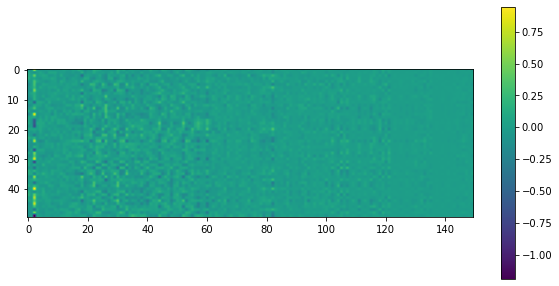

In [15]:
weights_layer1 = model.layer1.weight.data
# Converting the tensor to a NumPy array
compressor_mat = weights_layer1.cpu().numpy()
print(compressor_mat.shape)

plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()
#print(compressor_mat)

Most Important 25 Stats:
19.782568 bandpass_variance 0
7.4859457 edge_mean 1 0
7.0310884 edge_mean 1 2
6.657372 edge_mean 2 1
6.5422306 edge_correlation 3 (1, 3)
6.437154 edge_stop 1 3
6.2136555 edge_mean 2 3
6.161998 edge_correlation 2 (1, 3)
5.999291 edge_mean 1 3
5.4053283 edge_mean 1 1
5.3611846 edge_correlation 1 (1, 3)
5.335119 edge_stop 1 2
5.266037 edge_stop 1 1
5.221447 edge_correlation 2 (0, 2)
4.938521 edge_variance 1 3
4.793714 edge_variance 1 1
4.706029 edge_stop 1 0
4.583311 edge_mean 2 2
4.479349 mean
4.2818723 edge_correlation 1 (0, 2)
4.182035 edge_variance 2 3
4.1343307 edge_correlation (1, 2) 1
4.1144085 edge_correlation (1, 2) 3
3.953246 edge_stop 2 3
3.885125 edge_mean 2 0


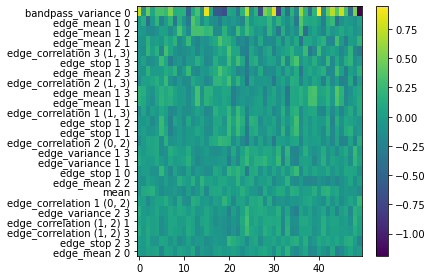

Least Important 25 Stats:
0.0589075 phase_correlation (3, 4) ei*di 1
0.061924797 phase_correlation (3, 4) ei*di 0
0.08657026 phase_correlation (2, 3) ei*di 0
0.08797253 edge_stop 4 3
0.092064634 phase_correlation (2, 3) ei*di 1
0.09959534 edge_stop 4 1
0.112540245 phase_correlation (2, 3) ei*di 2
0.120835684 phase_correlation (3, 4) ei*di 2
0.14062618 phase_correlation (3, 4) ei*di 3
0.1542507 phase_correlation (2, 3) ei*di 3
0.15740071 phase_correlation (1, 2) ei*di 0
0.21324603 phase_correlation (1, 2) ei*di 3
0.2372375 phase_correlation (3, 4) er*di 0
0.24230309 phase_correlation (1, 2) ei*di 2
0.29264614 phase_correlation (1, 2) ei*di 1
0.3594802 phase_correlation 4 er (1, 3)
0.3752873 phase_correlation (3, 4) er*di 1
0.39559987 phase_correlation 3 er (0, 2)
0.40992388 phase_correlation 4 er (0, 2)
0.4179026 phase_correlation (3, 4) er*di 2
0.47866336 phase_correlation (3, 4) er*di 3
0.5426002 edge_stop 3 1
0.54453486 edge_stop 3 3
0.61549985 phase_correlation 2 er (0, 2)
0.6461342

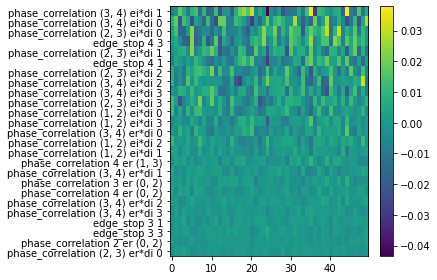

In [16]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the num_stats stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

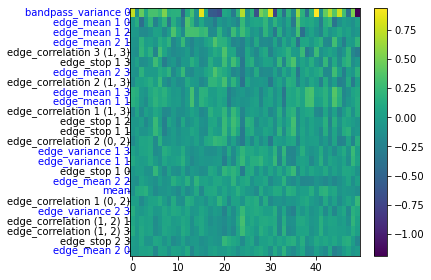

In [17]:

fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)

top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)))  # Only set the ticks, not the labels
ax.set_yticklabels([])  # Suppress the default ytick labels

# Place the ytick labels using ax.text and color those containing "kurtosis" or "mean"
for i, label in enumerate(top_stats):
    color = 'blue' if 'variance' in label or 'mean' in label or 'kurtosis' in label or 'skew' in label else 'black'
    ax.text(-0.5, i, label, va='center', ha='right', color=color)

plt.tight_layout()
plt.show()

In [18]:
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]

heegerbergen_indices = variance + mean + skew + kurtosis

all_indices = set(range(len(ostat_labels)))
remaining_indices = sorted(list(all_indices - set(heegerbergen_indices)))
#print(remaining_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  #@Mark: This should print 58.5

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:15] if index in heegerbergen_indices)

print(count)

58.5
8


In [20]:
# Compute the ranks
stat_index_list = list(stat_index_array)

ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Compute the mean rank
mean_rank = sum(ranks) / len(ranks) if ranks else None

print(mean_rank)  #  @Mark: This should print 54.26

54.26
